<a href="https://colab.research.google.com/github/mlukan/GDA3B2021/blob/main/NN/Stock_Prediction_Quest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction 
In this exercise you will work with stock market data. We use the data available at [Yahoo Finance](https://finance.yahoo.com/quote/DAX/history?period1=1478390400&period2=1604534400&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true)
You will build sequential models to predict the variations for Global X DAX Germany ETF (DAX). The goal is to predict whether the stock value is higher or lower than its actual value of previous day.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

In [2]:
np.__version__

'1.18.5'

### Loading and Preprocessing Data

In [45]:
# Loading training data
training_data = pd.read_csv("https://github.com/mlukan/GDA3B2021/raw/main/daxdata/dax_train_2019.csv.txt", sep=",")
#training_data = pd.read_csv("../daxdata/dax_train_2019.csv.txt", sep=",")

print(f"Training data column info:\n {training_data.dtypes}")
print(f"Training data shape is {training_data.shape}")

Training data column info:
 date          object
open         float64
high         float64
low          float64
close        float64
adj_close    float64
volume         int64
dtype: object
Training data shape is (644, 7)


In [46]:
# Loading testing data
testing_data = pd.read_csv("https://github.com/mlukan/GDA3B2021/raw/main/daxdata/dax_test_2019.csv.txt", sep=",")
#testing_data = pd.read_csv("../daxdata/dax_test_2019.csv.txt", sep=",")

print(f"Testing data column info:\n {testing_data.dtypes}")
print(f"Testing data shape is {testing_data.shape}")

Testing data column info:
 date          object
open         float64
high         float64
Low          float64
close        float64
adj_close    float64
volume         int64
dtype: object
Testing data shape is (148, 7)


In [5]:
len(testing_data)
testing_data.shape[0]

148

####  Are there any NaN values in training and testing data sets?

In [6]:

training_count_nan = training_data.shape[0] - training_data.count()
testing_count_nan = testing_data.shape[0] - testing_data.count()
print(f"Number of NaNs in training data columns:\n{training_count_nan}")
print(f"Number of NaNs in testing data columns:\n{testing_count_nan}")

Number of NaNs in training data columns:
date         0
open         0
high         0
low          0
close        0
adj_close    0
volume       0
dtype: int64
Number of NaNs in testing data columns:
date         0
open         0
high         0
Low          0
close        0
adj_close    0
volume       0
dtype: int64


In [7]:
testing_data.shape

(148, 7)

#### Preprocessing the data, extracting the features, and normalising the features using `preprocessing.MinMaxScaler` function from sklearn

We have provided you with the relevant function here. But we expect you to explore the data generated. 

What are the shapes?

Do a test whether features and labels correspond, i.e. whether the label for each sequence is the value following that sequence? 

Optional: Extend the function to include more features - and change it 
to choose a different column as target, i.e. adj_close


In [8]:
# Limiting the training and testing data to "open" column 
training_data_processed = training_data.iloc[:, 1:2].values
testing_data_processed = testing_data.iloc[:, 1:2].values

In [9]:
def create_features_labels(training_data, testing_data, scaler=MinMaxScaler(feature_range = (0, 1)), sequence_length=60):
    """
    Create feature and labels from training data
    :param training_data
    :param testing_data
    :param sequence_length
    :param scaler
    :return: Features and labels sets, and labels bins
    """
    features_set = []
    labels = []
    labels_bin = []
    test_features = []
    # Limiting the training and testing data to relevant column (here "open" column)
    training_data_processed = training_data.iloc[:, 1:2].values
    # Normalization: Transform features by scaling each feature in training to be in a range of (0, 1)
    training_data_processed = scaler.fit_transform(training_data_processed)
    # Preparing training data features and labels
    for i in range(sequence_length, len(training_data)):
        features_set.append(training_data_processed[i-sequence_length:i, 0])
        labels.append(training_data_processed[i, 0])
        # Fill binary labels
        if training_data_processed[i,0] > training_data_processed[i-1,0]:
            labels_bin.append(1)
        else:
            labels_bin.append(0)
    # Preparing the testing data features
    total = pd.concat((training_data['open'], testing_data['open']), axis=0)
    test_inputs = total[len(total) - len(testing_data) - sequence_length:].values
    test_inputs = test_inputs.reshape(-1,1)
    test_inputs = scaler.transform(test_inputs)

    for i in range(sequence_length, len(test_inputs)):
        test_features.append(test_inputs[i-sequence_length:i, 0])
    
    test_features = np.array(test_features)
    test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))
    features_set, labels, labels_bin = np.array(features_set), np.array(labels), np.array(labels_bin)
    return np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1)), labels, labels_bin, test_features, scaler

In [10]:
features_set, labels, labels_bin, test_features, scaler = create_features_labels(training_data, testing_data, MinMaxScaler(feature_range = (0, 1)), 60)

In [11]:
# What are the shapes?
for f in ['features_set', 'labels', 'labels_bin', 'test_features']:
    print(f,eval(f+".shape"))

features_set (584, 60, 1)
labels (584,)
labels_bin (584,)
test_features (148, 60, 1)


In [12]:


# Do a test whether features and labels correspond, i.e. whether the label for each sequence is the value following that sequence? 
ct=0
for f, l in  zip(features_set[1:,-1].flatten(),labels):
    if ct <10:
        print(f,l)
        ct+=1
    if f!=l:
        print(f,l,"does not match")
    

0.26552056022163883 0.26552056022163883
0.22827117748530812 0.22827117748530812
0.21489973399233353 0.21489973399233353
0.21107938978790752 0.21107938978790752
0.2053485391927925 0.2053485391927925
0.22540594320973684 0.22540594320973684
0.26170012050621994 0.26170012050621994
0.23686716684500153 0.23686716684500153
0.23113660278286563 0.23113660278286563
0.24641836164454256 0.24641836164454256


In [13]:
labels_bin=labels_bin.reshape(labels_bin.shape[0],1)

In [14]:
type(labels)

numpy.ndarray

### Model
In this section we ask you to build and train a LSTM neural network and use it predict the stock price variations on your testing data.

In [15]:
open_train=np.array(training_data['open'])
open_test=np.array(testing_data['open'])
dates_train=training_data['date']
dates_test=testing_data['date']

In [16]:
open_train=open_train.reshape(open_train.shape[0],1)
open_test=open_test.reshape(open_test.shape[0],1)


In [17]:
look_back=15
from keras.preprocessing.sequence import TimeseriesGenerator
train_generator = TimeseriesGenerator(open_train, open_train, length=look_back, batch_size=20)     
test_generator = TimeseriesGenerator(open_test, open_test, length=look_back, batch_size=1)

In [18]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
def lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(10,activation='relu',input_shape=(input_shape,1)))
    model.add(Dense(1))
    return model


Compile your model, train it and evaluate it. 

What is your mse - and what is your accuracy (note that you have two different types of labels readily available to you). 



In [19]:
#del lstmod
lstmod=lstm_model(look_back)
lstmod.compile(optimizer='adam', loss='mse')

num_epochs = 25
lstmod.fit(train_generator, epochs=num_epochs, verbose=1)


Epoch 1/25
32/32 [==============================] - 0s 3ms/step - loss: 210.8035
Epoch 2/25
32/32 [==============================] - 0s 3ms/step - loss: 5.0903
Epoch 3/25
32/32 [==============================] - 0s 3ms/step - loss: 0.5879
Epoch 4/25
32/32 [==============================] - 0s 3ms/step - loss: 0.3791
Epoch 5/25
32/32 [==============================] - 0s 3ms/step - loss: 0.3492
Epoch 6/25
32/32 [==============================] - 0s 3ms/step - loss: 0.3518
Epoch 7/25
32/32 [==============================] - 0s 3ms/step - loss: 0.3872
Epoch 8/25
32/32 [==============================] - 0s 3ms/step - loss: 0.3841
Epoch 9/25
32/32 [==============================] - 0s 3ms/step - loss: 0.4045
Epoch 10/25
32/32 [==============================] - 0s 3ms/step - loss: 0.3594
Epoch 11/25
32/32 [==============================] - 0s 3ms/step - loss: 0.3657
Epoch 12/25
32/32 [==============================] - 0s 3ms/step - loss: 0.3618
Epoch 13/25
32/32 [============================

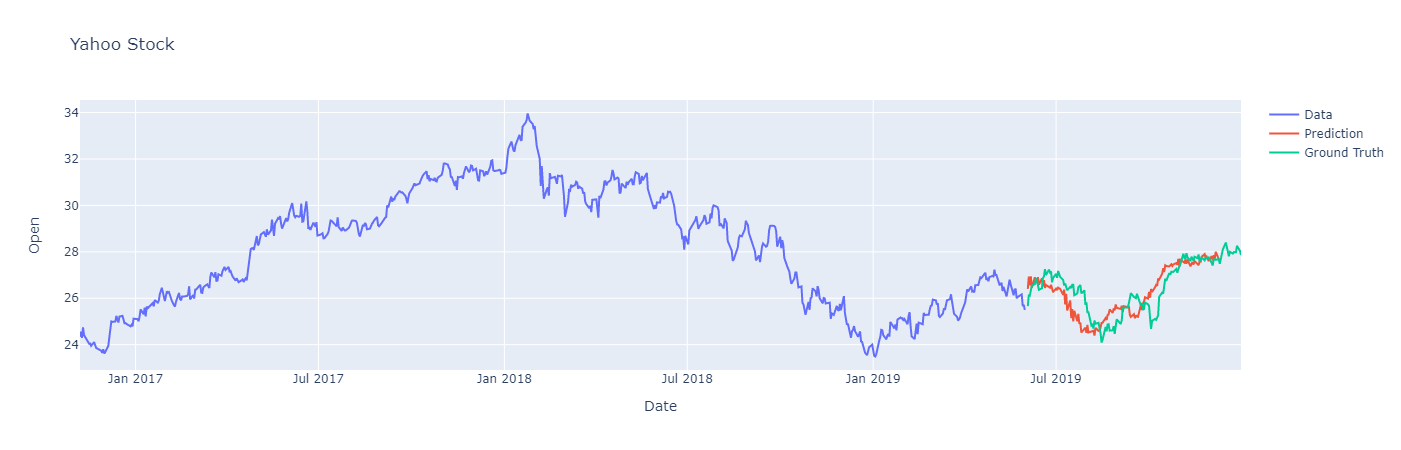

In [44]:
import plotly.graph_objects as go

prediction = lstmod.predict(test_generator)

open_train = open_train.reshape((-1))
open_test = open_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = dates_train,
    y = open_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = dates_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = dates_test,
    y = open_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "Yahoo Stock",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Open"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show();

In [27]:
def predict(num_prediction, model,data,look_back):
    prediction_list = data[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(num_prediction,dates):
    last_date = dates.values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

open_data=np.concatenate((open_train,open_test),axis=0)
dates=dates_train.append(dates_test)

num_prediction = 30
forecast = predict(num_prediction, lstmod,open_data,look_back)
forecast_dates = predict_dates(num_prediction,dates)

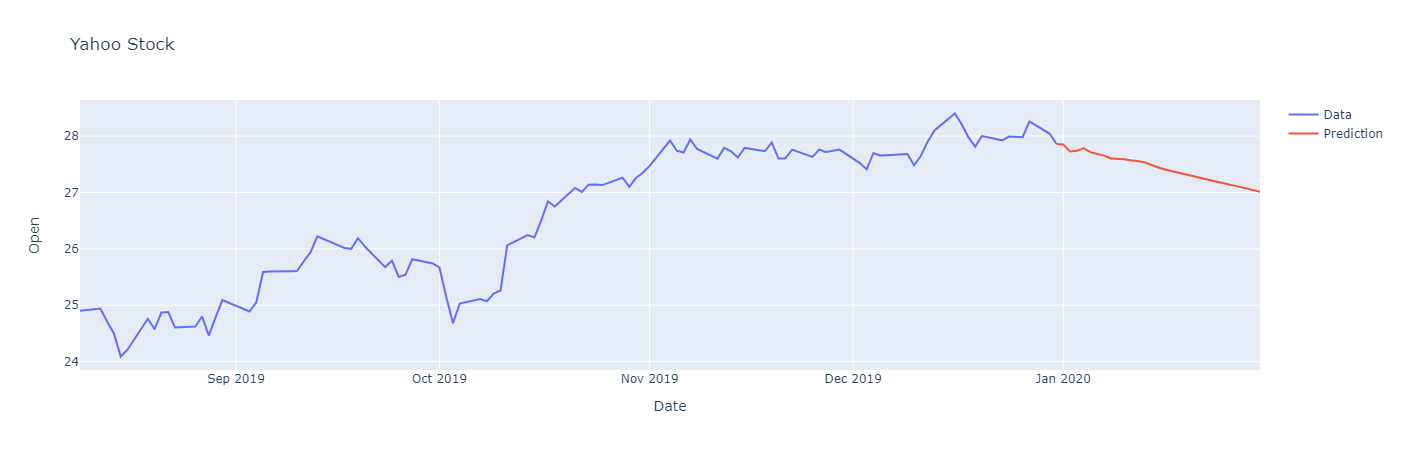

In [43]:
import plotly.graph_objects as go
open_data=open_data.reshape((-1))
trace1 = go.Scatter(
    x = dates[-100:],
    y = open_data[-100:],
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = forecast_dates,
    y = forecast,
    mode = 'lines',
    name = 'Prediction'
)

layout = go.Layout(
    title = "Yahoo Stock",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Open"}
)
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show();

Optional: Try your model with more features, try with different sequence lengths (this is a hyperparameter) - and try with the "real" Dax Performance Index data also provided (which reaches back longer). If you do so, you will have to split the data into training and test sets first). 